# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Importamos librerias necesarias para el proyecto
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Cargar los datos
#file_path = 'datasets/taxi.csv'
file_path = '/datasets/taxi.csv'
data = pd.read_csv(file_path, index_col=0, parse_dates=[0])

In [3]:
# Visualizar los primeros registros
display(data.head())

# Resumir la información del DataFrame
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [4]:
# Remuestrear los datos a intervalos de una hora
data_resampled = data.resample('H').sum()

# Visualizar los datos remuestreados
display(data_resampled.head())

print(data_resampled.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


## Análisis

In [5]:
# Descriptiva de los datos
print("Estadísticas descriptivas de los datos remuestreados:")
display(data_resampled.describe())

Estadísticas descriptivas de los datos remuestreados:


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


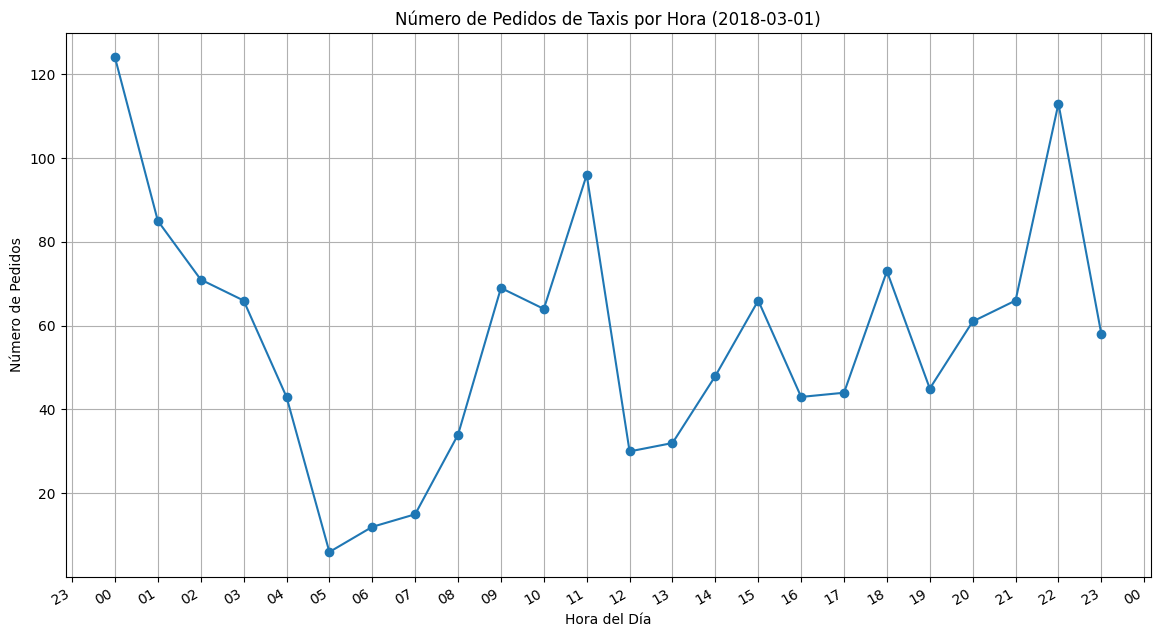

In [6]:
# Filtrar datos para un día específico (por ejemplo, 2018-03-01)
specific_day = '2018-03-01'
data_day = data_resampled.loc[specific_day]

plt.figure(figsize=(14, 8))

plt.plot(data_day.index, data_day['num_orders'], marker='o')

plt.title(f'Número de Pedidos de Taxis por Hora ({specific_day})')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Pedidos')
plt.grid(True)
# Formatear las etiquetas del eje X para que muestren solo la hora
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()  # Ajustar automáticamente el formato de la fecha
plt.show()

#### Grafica: Número de pedidos de taxis por hora (2018-03-01)
La informacion de esta grafica corresponde a un dia en especifico

Pico a media noche
- La demanda de taxi alcanza el punto mas alto de pedidos por hora alrededor de la medianoche disminuyendo hasta las 6 AM

Minimo en la madrugada
- La demanda cae a menos de 20 pedidos por hora entre las 3 y las 6 AM

Aumento en la mañana 
- Depues de las 6 am la demanda sube alcanzando un pico hasta las 11 AM para disminuir drasticamente

Visibilidad durante el dia: 
- Se presentan fluctuaciones de pedidos a lo largo del dia presentando un incremento a partir de las 6 PM y alcanzando un pico a las 10 AM

Interpretacion:

- La demanda de taxis tiene dos periodos principales de alta demanda (medianoche y 10 p.m.) y baja demanda en la madrugada (3-6 a.m.).
- El aumento de la mañana sugiere actividad laboral o vuelos temprano


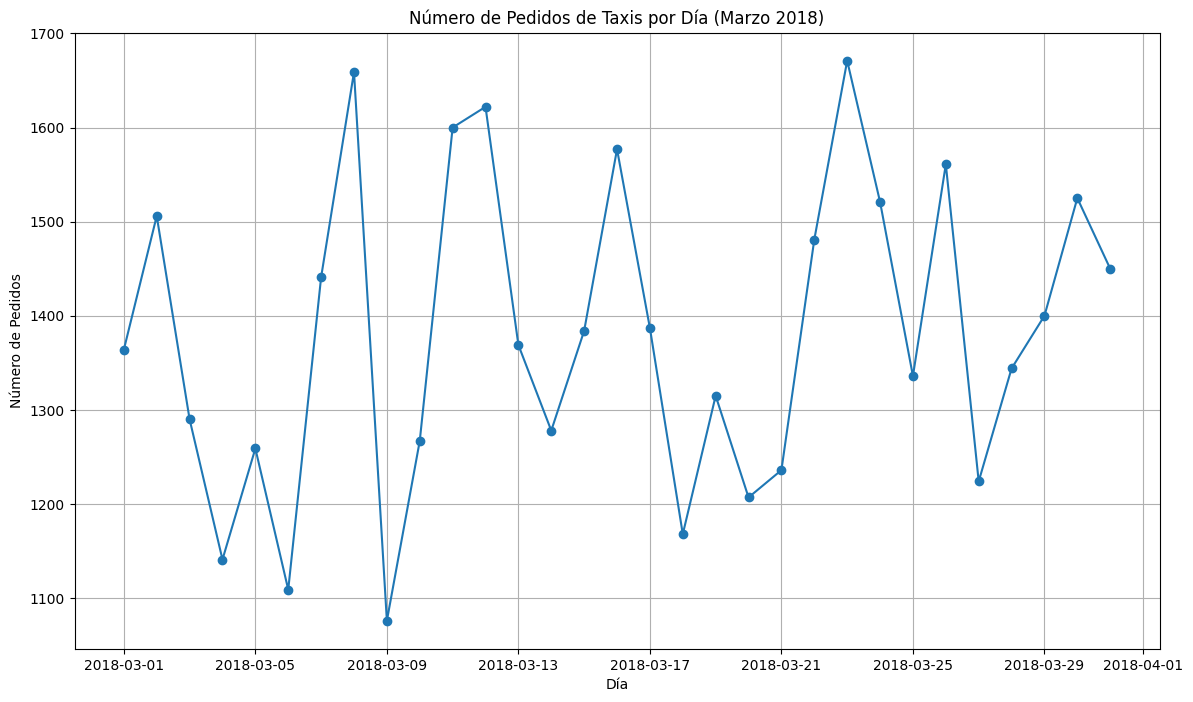

In [7]:
# Gráfica 2: Total de Pedidos por Día durante un Mes
start_date = '2018-03-01'
end_date = '2018-03-31'
data_month = data_resampled.loc[start_date:end_date]
data_daily = data_month.resample('D').sum()

plt.figure(figsize=(14, 8))
plt.plot(data_daily.index, data_daily['num_orders'], marker='o')
plt.title(f'Número de Pedidos de Taxis por Día (Marzo 2018)')
plt.xlabel('Día')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.show()


#### Grafica: Número de pedidos de taxis por Dia (Marzo 2018)

La informacion de esta grafica corresponde a un mes en especifico.

Alta Variabilidad Diaria:

- La cantidad de pedidos de taxis varía significativamente de un día a otro durante marzo de 2018, con valores que oscilan entre aproximadamente 1100 y 1700 pedidos por día.

Picos Principales:

- Se observan picos importantes en la demanda los días 4, 12, 21 y 31 de marzo, con el número de pedidos superando los 1600.

Mínimos Significativos:

- Los mínimos significativos se presentan alrededor del 5, 9, y 17 de marzo, con el número de pedidos descendiendo por debajo de los 1200.


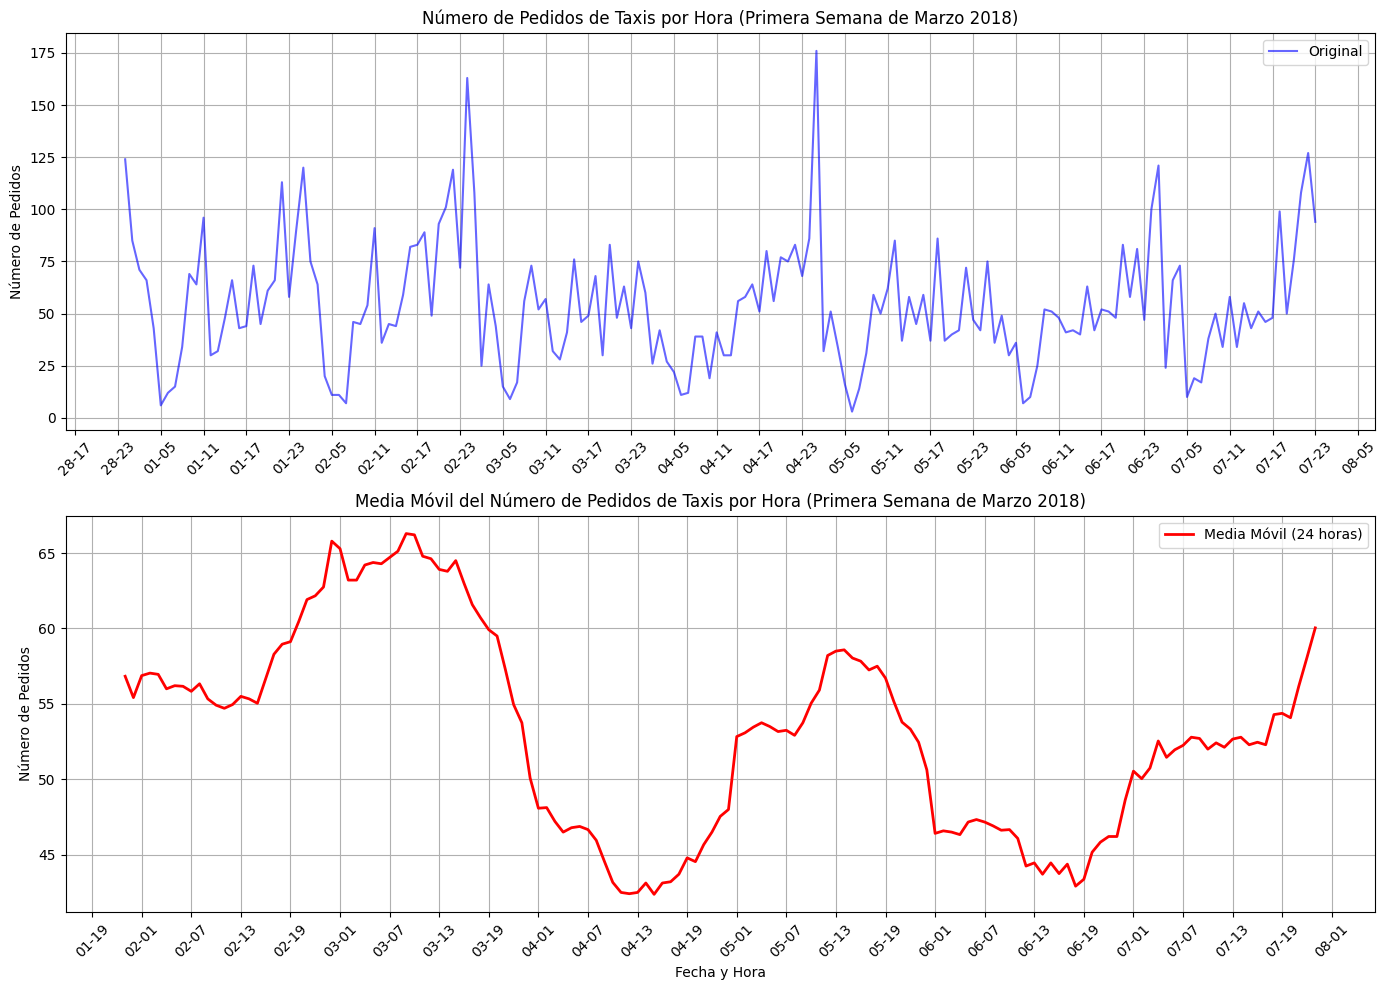

In [8]:
# Dividir la gráfica en semanas para una mejor visualización
start_date = '2018-03-01'
end_date = '2018-03-07'  # Visualizar solo la primera semana de marzo
data_week = data_resampled.loc[start_date:end_date]
data_smoothed_week = data_week['num_orders'].rolling(window=24).mean()

plt.figure(figsize=(14, 10))

# Subgráfica 1: Serie original
ax1 = plt.subplot(2, 1, 1)
plt.plot(data_week.index, data_week['num_orders'], label='Original', color='blue', alpha=0.6)
plt.title('Número de Pedidos de Taxis por Hora (Primera Semana de Marzo 2018)')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Subgráfica 2: Media móvil
ax2 = plt.subplot(2, 1, 2)
plt.plot(data_week.index, data_smoothed_week, label=f'Media Móvil (24 horas)', color='red', linewidth=2)
plt.title('Media Móvil del Número de Pedidos de Taxis por Hora (Primera Semana de Marzo 2018)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


#### Grafica numero de pedidos de taxi por hora (Primera semana de marzo 2018)

Subgráfica 1: Serie Original (Línea Azul)

Alta Variabilidad Horaria:

- La serie temporal muestra una alta variabilidad en el número de pedidos de taxis por hora durante la primera semana de marzo de 2018.
- Se observan múltiples picos y valles que indican fluctuaciones significativas en la demanda horaria.

Pico Máximo:

- Se observa un pico significativo alrededor del 4 de marzo, donde el número de pedidos alcanza su punto más alto, cerca de 175 pedidos por hora.

Patrón Diurno:

- A lo largo de los días, se pueden observar ciertos patrones repetitivos, con picos y valles recurrentes. Esto sugiere que hay momentos específicos del día con mayor y menor demanda de taxis.

Subgráfica 2: Media Móvil de 24 Horas (Línea Roja)

Suavizado de la Serie:

- La media móvil de 24 horas suaviza las fluctuaciones de la serie original, revelando un patrón más claro y estable de la demanda subyacente.
- La línea roja muestra una tendencia general con menos ruido, facilitando la identificación de patrones y tendencias diurnas.

Patrones Diurnos Claros:

- La media móvil destaca picos recurrentes durante la mañana y la tarde. Estos picos suelen coincidir con las horas de mayor actividad diaria, como el inicio y el final de la jornada laboral.

Tendencias de Demanda:

- La gráfica muestra una tendencia descendente a lo largo de la semana, con una recuperación hacia el final del periodo. Esto podría indicar variaciones en la demanda semanal, como una menor demanda durante los días laborales y un aumento hacia el fin de semana.

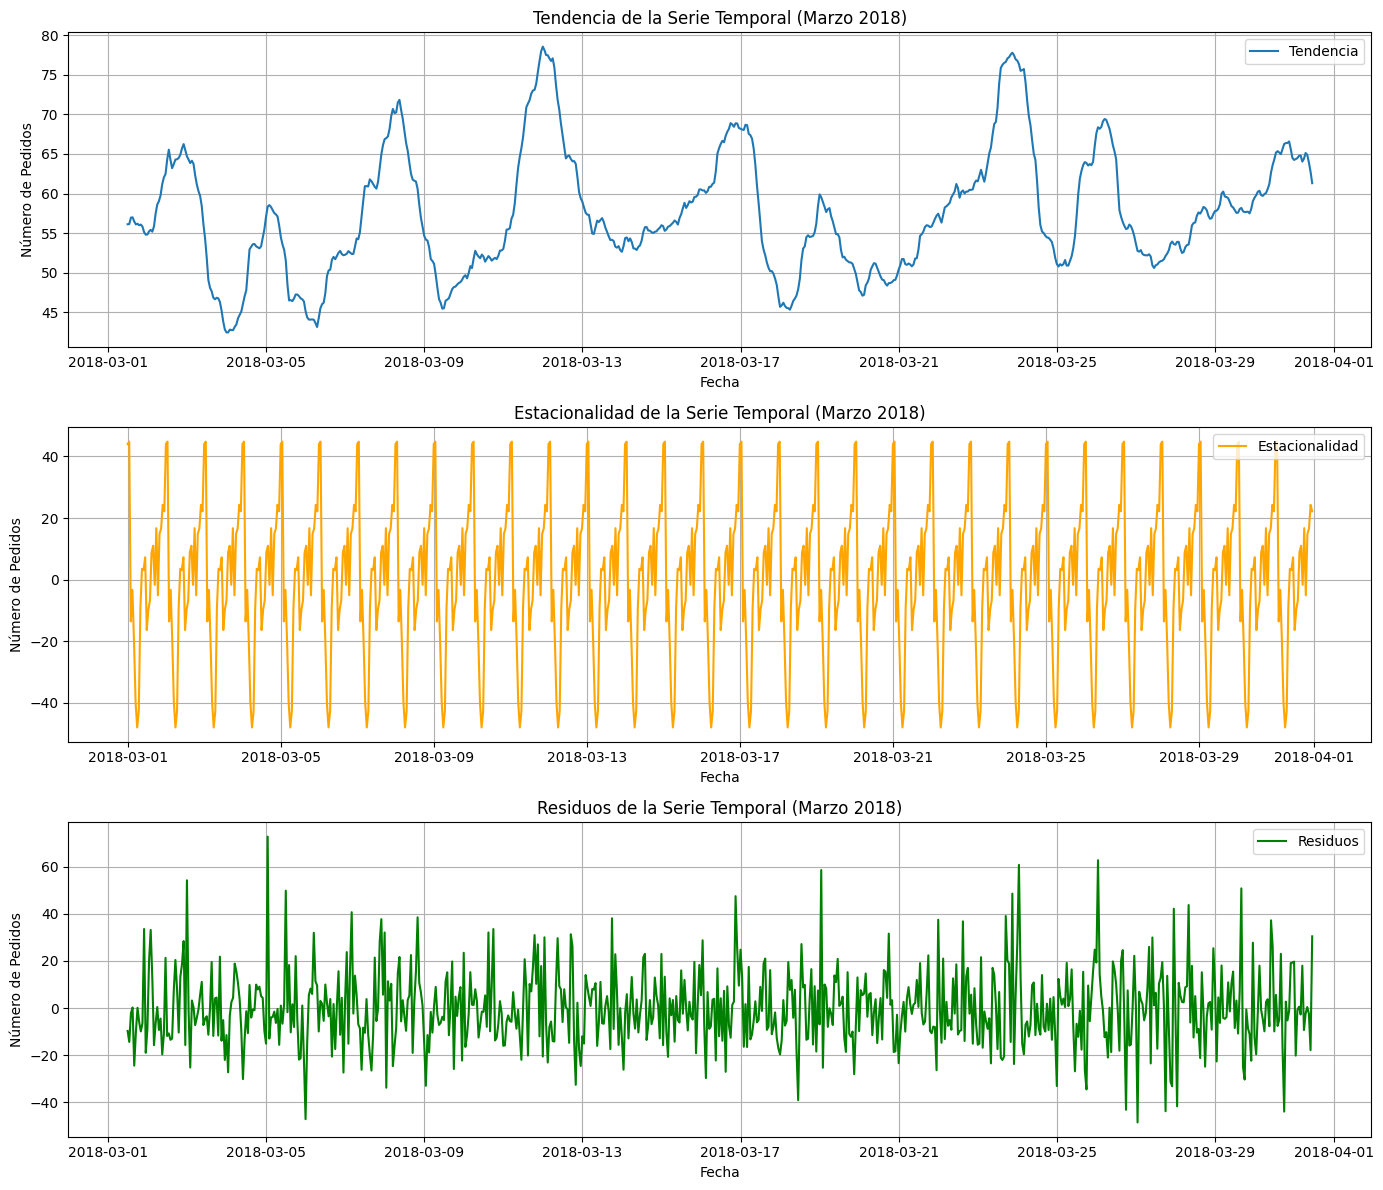

In [9]:
# Descomposición de la serie temporal para el mes específico
result = seasonal_decompose(data_month['num_orders'], model='additive', period=24)

# Crear la figura con subplots separados
plt.figure(figsize=(14, 12))

# Componente de tendencia
plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Tendencia')
plt.title('Tendencia de la Serie Temporal (Marzo 2018)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)

# Componente estacional
plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Estacionalidad', color='orange')
plt.title('Estacionalidad de la Serie Temporal (Marzo 2018)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)

# Componente residual
plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residuos', color='green')
plt.title('Residuos de la Serie Temporal (Marzo 2018)')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Grafica: Análisis de la Gráfica: Descomposición de la Serie Temporal (Marzo 2018)

1. Componente de Tendencia (Línea Azul)
- Descripción: La tendencia muestra la dirección general de los datos a lo largo del tiempo, eliminando las fluctuaciones estacionales y residuales.
- Observaciones:
    - Se observan ciclos claros de aumento y disminución en la demanda de taxis a lo largo de marzo de 2018.
    - Los picos de la tendencia parecen coincidir con fines de semana, lo que sugiere una mayor demanda de taxis durante esos días.
    - La tendencia muestra una variabilidad semanal, con aumentos y descensos periódicos en la demanda.
2. Componente Estacional (Línea Naranja)

- Descripción: La estacionalidad muestra patrones repetitivos y predecibles a intervalos regulares.
- Observaciones:
    - Se observa un patrón estacional diario muy claro, con picos y valles que se repiten aproximadamente cada 24 horas.
    - Los picos diurnos se producen generalmente durante las horas de la mañana y la tarde, lo que es consistente con las horas de mayor actividad diaria.
    - La estacionalidad resalta la naturaleza cíclica de la demanda de taxis, indicando horas pico diarias específicas.
3. Componente de Residuos (Línea Verde)

- Descripción: Los residuos representan la parte de la serie temporal que no puede ser explicada por la tendencia ni la estacionalidad. Son esencialmente el "ruido" o las fluctuaciones aleatorias.
- Observaciones:
    - Los residuos muestran una variabilidad significativa, con múltiples picos y valles.
    - Algunos picos altos en los residuos podrían indicar eventos especiales o anomalías que no siguen los patrones normales de tendencia y estacionalidad.
    - La variabilidad de los residuos parece ser más alta durante ciertos periodos, lo que sugiere que hay factores adicionales afectando la demanda en esos momentos.

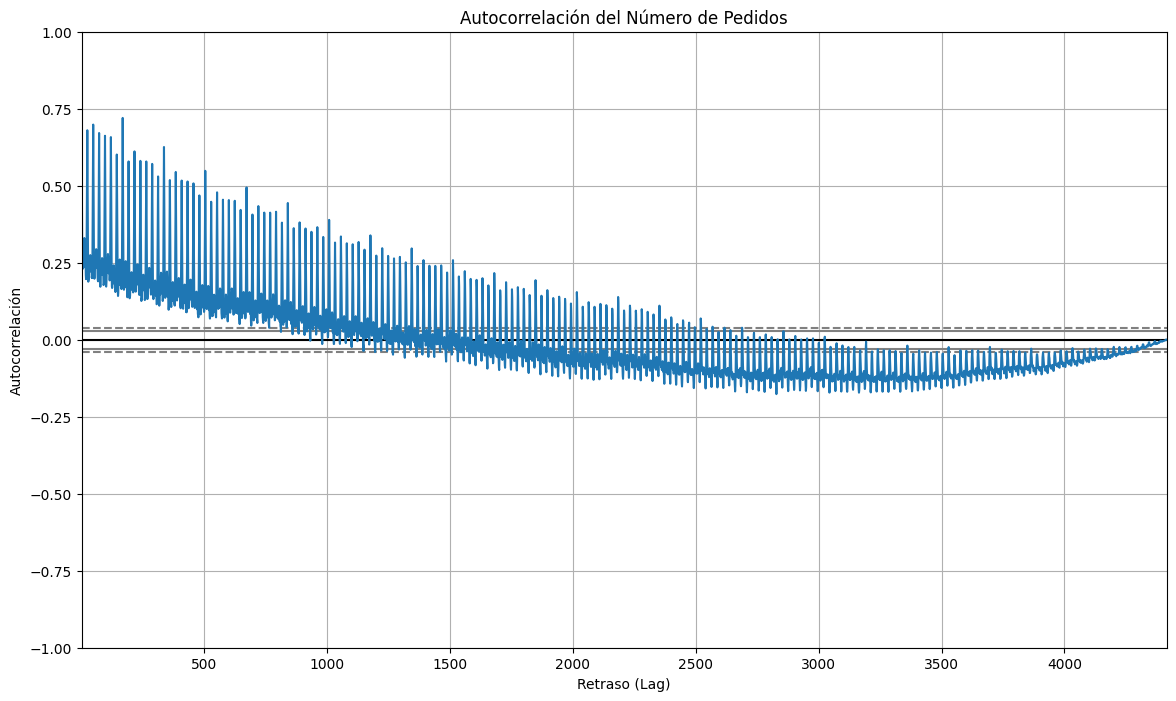

In [10]:
# Visualización de autocorrelaciones
plt.figure(figsize=(14, 8))
autocorrelation_plot(data_resampled['num_orders'])
plt.title('Autocorrelación del Número de Pedidos')
plt.xlabel('Retraso (Lag)')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()

##### Gráfica: Autocorrelación del Número de Pedidos
Descripción:
-   La gráfica de autocorrelación muestra la correlación entre los valores de la serie temporal y sus versiones desplazadas en el tiempo.

Observaciones:

1. Alta Autocorrelación Inicial:
    - Los valores de autocorrelación son altos para lags pequeños, indicando que los pedidos de taxis en una hora están altamente influenciados por los pedidos en las horas recientes.

2. Decrecimiento Gradual:
    - La autocorrelación disminuye gradualmente a medida que aumenta el lag, mostrando que la influencia de un punto de datos disminuye con el tiempo.

3. Oscilaciones y Estacionalidad:
    - Las oscilaciones indican la presencia de patrones estacionales o cíclicos, sugiriendo ciclos diarios o semanales en la demanda de taxis.

4. Valores Negativos y Ruido:
    - A lags mayores, la autocorrelación fluctúa alrededor de cero, indicando ruido o variabilidad aleatoria en la serie temporal.

## Formación

In [11]:
# Crear nuevas características a partir de la columna de fechas
data_resampled['year'] = data_resampled.index.year
data_resampled['month'] = data_resampled.index.month
data_resampled['day'] = data_resampled.index.day
data_resampled['hour'] = data_resampled.index.hour
data_resampled['dayofweek'] = data_resampled.index.dayofweek

# Definir características (X) y objetivo (y)
X = data_resampled[['year', 'month', 'day', 'hour', 'dayofweek']]
y = data_resampled['num_orders'].values

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])


Tamaño del conjunto de entrenamiento: 3974
Tamaño del conjunto de prueba: 442


In [12]:
# Modelo de Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
print("RMSE Regresión Lineal en el conjunto de entrenamiento:", rmse_train_lr)
print("RMSE Regresión Lineal en el conjunto de prueba:", rmse_test_lr)

RMSE Regresión Lineal en el conjunto de entrenamiento: 34.43111380550365
RMSE Regresión Lineal en el conjunto de prueba: 63.789001231137746


In [13]:
# Ajuste de Hiperparámetros para LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}
model_lgb = lgb.LGBMRegressor()
grid_search_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid_lgb, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_lgb.fit(X_train, y_train)
best_params_lgb = grid_search_lgb.best_params_
print("Mejores hiperparámetros LightGBM:", best_params_lgb)
best_model_lgb = grid_search_lgb.best_estimator_
y_pred_train_best_lgb = best_model_lgb.predict(X_train)
y_pred_test_best_lgb = best_model_lgb.predict(X_test)
rmse_train_best_lgb = np.sqrt(mean_squared_error(y_train, y_pred_train_best_lgb))
rmse_test_best_lgb = np.sqrt(mean_squared_error(y_test, y_pred_test_best_lgb))
print("RMSE LightGBM ajustado en el conjunto de entrenamiento:", rmse_train_best_lgb)
print("RMSE LightGBM ajustado en el conjunto de prueba:", rmse_test_best_lgb)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 3179, number of used features: 4
[LightGBM] [Info] Start training from score 83.504247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 3179, number of used features: 4
[LightGBM] [Info] Start training from score 81.808430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=

In [14]:
# Ajuste de Hiperparámetros para XGBoost
param_grid_xgb = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}
model_xgb = xgb.XGBRegressor()
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print("Mejores hiperparámetros XGBoost:", best_params_xgb)
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_train_best_xgb = best_model_xgb.predict(X_train)
y_pred_test_best_xgb = best_model_xgb.predict(X_test)
rmse_train_best_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_best_xgb))
rmse_test_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_best_xgb))
print("RMSE XGBoost ajustado en el conjunto de entrenamiento:", rmse_train_best_xgb)
print("RMSE XGBoost ajustado en el conjunto de prueba:", rmse_test_best_xgb)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
RMSE XGBoost ajustado en el conjunto de entrenamiento: 18.381401907461665
RMSE XGBoost ajustado en el conjunto de prueba: 42.676681717965664


## Prueba

In [15]:
### Prueba
# Resumen de resultados
results = {
    'Modelo': ['Regresión Lineal', 'LightGBM', 'XGBoost'],
    'RMSE Entrenamiento': [rmse_train_lr, rmse_train_best_lgb, rmse_train_best_xgb],
    'RMSE Prueba': [rmse_test_lr, rmse_test_best_lgb, rmse_test_best_xgb]
}
results_df = pd.DataFrame(results)
display(results_df)


,Modelo,RMSE Entrenamiento,RMSE Prueba
0,Regresión Lineal,34.431114,63.789001
1,LightGBM,17.132956,41.928059
2,XGBoost,18.381402,42.676682


### Conclusion

1. Regresion lineal:
    - RMSE Entrenamiento: 34.431114
    - RMSE Prueba: 63.789001
    - Analisis: 
        - La regresión lineal muestra una diferencia significativa entre los RMSE de entrenamiento y prueba.
        - Esta diferencia indica que el modelo de regresión lineal no generaliza bien a nuevos datos, probablemente debido a su simplicidad y a la incapacidad de capturar las complejidades de los patrones de demanda de taxis.

LightGBM:

- RMSE Entrenamiento: 17.132956
- RMSE Prueba: 41.928059
- Análisis:
    - LightGBM tiene un rendimiento notablemente mejor en el conjunto de prueba en comparación con la regresión lineal.
    - El modelo muestra una mejor generalización y captura más adecuadamente las complejidades y patrones en los datos de demanda de taxis.
    - Este resultado destaca la capacidad de LightGBM para manejar relaciones no lineales y características complejas en los datos.

XGBoost:

- RMSE Entrenamiento: 18.381402
- RMSE Prueba: 42.676682
- Análisis:
    - XGBoost presenta un rendimiento similar al de LightGBM, con un RMSE ligeramente mayor en el conjunto de prueba.
    - Aunque el rendimiento es cercano, LightGBM aún supera a XGBoost en términos de precisión en las predicciones.

#### El Mejor Modelo: LightGBM

Basado en los resultados de RMSE en el conjunto de prueba, LightGBM es el modelo que proporciona las predicciones más precisas y generaliza mejor a los datos no vistos.
La menor diferencia entre el RMSE de entrenamiento y prueba sugiere que LightGBM no solo es preciso sino también robusto y menos propenso al sobreajuste en comparación con los otros modelos evaluados.


# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48